# Indoor HIIT 动作识别
> 山东大学（威海）<br>
> 18级 数据科学与人工智能 孙易泽

## 简介
本项目为通过**微信小程序进行动作的识别**，项目选取了徒手侧平举、前后交叉小跳、开合跳、半蹲四个动作，在测试者左手手持手机的情况下，利用微信小程序实时采集手机的六轴数据，并用**随机森林模型**和**波峰检测法**，对测试者做出的动作进行实时的识别和计数。


## 数据采集
项目初期需要先进行数据收集，用于生成机器学习模型。
### 1.选取动作
在用户左手手持手机的前提下，为了保证各个动作存在一定的区分度，我们最终决定选择徒手侧平举、前后交叉小跳、开合跳、半蹲四个动作，作为项目的实验动作。
### 2.数据收集
利用微信小程序收集数据，本项目共收集了约50名测试者的数据，四个动作共有302条采集记录，每条采集记录包括20秒的加速计和陀螺仪的数据，以及20秒内动作次数。在采集过程中，测试者需要在20秒的时间里连续完成某一测试动作，在测试者完成动作后，会将20秒的六轴数据以及测试者20秒内所做动作次数录入到数据库当中。

因为手机系统在调用加速计和陀螺仪时，调用时间存在差异，所以我对ios用户和Android用户的数据分开进行了采集。其中苹果用户的六轴20ms采样一次，安卓用户六轴60ms采样一次，在最后实际运用时也分开使用。



## 数据处理
在数据处理步骤中，将会使用**巴特沃斯低通滤波器**，对数据进行滤波处理，再将数据以**2秒的窗口和50%重叠率**进行预处理。

*因为ios和Android采样频率的不同，在之后所有的操作中，ios和Android的数据会分开进行处理，但处理方式基本一致。以下操作均以苹果用户数据为例。*

### 1.滤波处理
首先使用巴特沃斯滤波器进行滤波，苹果采样频率为50hz,信号本身最大的频率为5hz，截止频率为5hz,则wn = 2 * 5 / 50 = 0.2。Wn = 0.2

我们选取一段测试数据的加速计x轴，并将滤波前后的图像进行对比。首先对数据进行滤波：

In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import json
import os

fopen = open(os.path.abspath('./data/rawdata/data.json'), 'r')
data = json.loads(fopen.readline())['accx']
fopen.close()
b, a = signal.butter(8, 0.2, 'lowpass')
filtedData = signal.filtfilt(b, a, data)


然后将滤波图像画出，观察滤波前后变化：

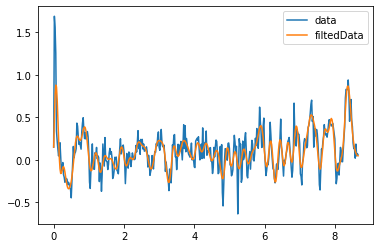

In [2]:
x = np.arange(0, len(data)*2/100, 0.02)
plt.plot(x, data, label="data")
plt.plot(x, filtedData, label="filtedData")
plt.legend()
plt.show()

可以看到滤波后的数据能够一定程度的减少了干扰，还原了数据。

接下来我们用2s的窗口对20秒的数据进行分割，并保证有50%的重叠率，以下是完整代码：

In [3]:
from scipy import signal
import numpy as np
import json
import csv
import os


print('Preprocess Data')
# 打开原数据和将要写入的文件
name = ['accx', 'accy', 'accz', 'gyrx', 'gyry', 'gyrz', 'tag']
fopen = open(os.path.abspath('./data/rawdata/data.json'), 'r')
for i1 in range(7):
    locals()[name[i1]] = open(os.path.abspath('./data/processdata/' + name[i1] + '.csv'), 'w', newline='')
# 设置低通滤波器参数
b, a = signal.butter(8, 0.2, 'lowpass')

# 主函数
for line in fopen:
    line = json.loads(line)
    if line['type'] == 1:
        # 将六个轴数据分别写入csv
        for i2 in range(6):
            data = np.array(line[name[i2]])
            data = data[50:1050]
            filtedData = signal.filtfilt(b, a, data)
            # 设置50%的重叠率
            for i3 in range(19):
                temp = filtedData[i3 * 50: (i3 + 2) * 50]
                writer = csv.writer(locals()[name[i2]])
                writer.writerow(temp)
                if i2 == 0:
                    csv.writer(locals()[name[6]]).writerow(str(int(line['activity'])))
fopen.close()
for i1 in range(7):
    locals()[name[i1]].close()
print('Finish')

Preprocess Data
Finish


## 特征选取
在本步骤过程中，我们将先提取一定特征，并对特征进行筛选，选取对机器学习有用的特征。
### 1.初步选取
我们要对预处理过后的数据，提取时域和频域上的特征。在首次提取特征时，我们尽可能多的选取特征。一共选取了以下特征：

|名称|定义|
|------ | ------ |
|min()|数组中最小值|
|max()|数组中最大值|
|mean()|平均值|
|median()|中位数|
|mad()|中值绝对偏差|
|std()|标准差|
|skew()|时域信号的偏度|
|kurtosis()|时域信号的峰度|
|iqr()|四分位数|
|energy()|能量度量|
|wskew()|频域信号的偏度|
|wkurtosis()|频域信号的峰度|

利用python的scipy包对六个轴的以上特征分别进行提取，并保存为feature.py作为特征提取文件。代码如下：

In [4]:
import numpy as np
from scipy import stats
from scipy.fftpack import fft


class getFeature():
    def get_all_feature(self, inputs):
        inputs = np.array(inputs)
        # 最小值
        min = np.min(inputs)
        # 最大值
        max = np.max(inputs)
        # 均值
        mean = np.mean(inputs)
        # 中值
        median = np.median(inputs)
        # 中值绝对偏差
        mad = stats.median_absolute_deviation(inputs)
        # 标准差
        std = np.std(inputs, ddof=1)
        # 偏度
        skew = stats.skew(inputs)
        # 峰度
        kurtosis = stats.kurtosis(inputs)
        # 四分位数范围
        iqr = stats.iqr(inputs)
        # 能量度量
        energy = self.energy(inputs)
        # FFT变换
        process = np.abs(fft(inputs)) / len(inputs) / 2
        # 频域偏度系数
        wskew = stats.skew(process)
        # 频域峰度系数
        wkurtosis = stats.kurtosis(process)
        # 将所有特征合并为数组
        array = [min, max, mean, median, mad, std, skew, kurtosis, iqr, energy, wskew, wkurtosis]
        return array

    # 计算能量度量
    def energy(self, inputs):
        return np.dot(inputs, np.transpose(inputs))/len(inputs)

写好feature.py特征提取文件后，运行以下主函数对特征提取文件进行调用

In [5]:
import pandas as pd
import numpy as np
import os
import csv
import sys
sys.path.append('./feature/select')
import feature_test


# 读取feature文件的类
feature_class = feature_test.getFeature()
name = ['accx', 'accy', 'accz', 'gyrx', 'gyry', 'gyrz']

# 六个轴分别计算特征
for i1 in range(6):
    fopen = open(os.path.abspath('./data/featuredata/' + name[i1] + '.csv'), 'w', newline='')
    data = pd.read_csv(os.path.abspath('./data/processdata/' + name[i1] + '.csv'),  header=None)
    # 将特征写入csv文件
    for i2 in range(len(data)):
        row = np.array(data.iloc[i2, :])
        outputs = feature_class.get_all_feature(row)
        csv.writer(fopen).writerow(outputs)
    fopen.close()

# 将六轴的特征合并后写入csv
fopen = open(os.path.abspath('./data/featuredata/total.csv'), 'w', newline='')
for i1 in range(6):
    locals()[name[i1]] = pd.read_csv(os.path.abspath('./data/featuredata/' + name[i1] + '.csv'),  header=None)
# 合并六个轴的数据
for i2 in range(len(locals()[name[0]])):
    total = np.append(accx.iloc[i2, :], accy.iloc[i2, :])
    total = np.append(total, accz.iloc[i2, :])
    total = np.append(total, gyrx.iloc[i2, :])
    total = np.append(total, gyry.iloc[i2, :])
    total = np.append(total, gyrz.iloc[i2, :])
    csv.writer(fopen).writerow(total)
fopen.close()

### 2.筛选特征
到此为止全部特征提取就已经完成，但为了进一步简化代码，减小计算量，接下来我们将通过**方差选择法**，对提取好的特征进行筛选

In [6]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler


# 导入处理好文件
inputs = pd.read_csv(os.path.abspath('./data/featuredata/total.csv'), header=None)
inputs = StandardScaler().fit_transform(inputs)

# 列出每个特征
feature = ['min', 'max', 'mean', 'median', 'mad', 'std', 'skew', 'kurtosis', 'iqr', 'energy', 'wskew', 'wkurtosis']
featureList = np.zeros(len(feature))

# 逐个计算方程
for i in range(np.shape(inputs)[1]):
    var = np.var(inputs[:, i])
    # 设定阈值
    if var > 1:
        featureList[i % len(feature)] += 1

# 将结果打印出来
print('方差筛选后，六个轴符合阈值出现的次数:')
for i in range(len(featureList)):
    print(feature[i], '=', int(featureList[i]), end=', ')

方差筛选后，六个轴符合阈值出现的次数:
min = 2, max = 2, mean = 1, median = 0, mad = 0, std = 0, skew = 0, kurtosis = 0, iqr = 2, energy = 1, wskew = 2, wkurtosis = 2, 

根据观察，我们可以看出：最大值、最小值、均值、四分位数、能量度量、频域偏度、频域峰度方差较大，有较好的分类效果。所以在接下来实际运用时，我们仅保留这些特征。

## 模型选择
### 1.选择模型
在此步骤，我们将从支持向量机、神经网络、随机森林和k临近法这四个机器学习模型中，选出正确率较高的一个，并加以改进。

首先将数据打乱顺序洗牌，并放入机器学习模型中计算正确率：

In [7]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('./machineLearning/compare')
import SVM
import RF
import NN
import KNN


# 选取随机数种子
np.random.seed(seed=10)
# 读取数据
inputs = pd.read_csv(os.path.abspath('./data/featuredata/total.csv'), header=None)
outputs = pd.read_csv(os.path.abspath('./data/processdata/tag.csv'), header=None)
# 将数据顺序打乱
train = np.array(pd.concat([inputs, outputs], axis=1))
np.random.shuffle(train)
# 分成输入和结果
inputs = pd.DataFrame(train).iloc[:, :-1]
outputs = pd.DataFrame(train).iloc[:, -1]

# 对四个模型分别进行训练，并进行十折交叉验证
result1 = SVM.model(inputs, outputs)
result2 = NN.model(inputs, outputs)
result3 = RF.model(inputs, outputs)
result4 = KNN.model(inputs, outputs)

# 输出各个算法交叉验证准确率的平均值
print('SVM: mean accuracy = {:.3f}'.format(result1))
print('NN: mean accuracy = {:.3f}'.format(result2))
print('RF: mean accuracy = {:.3f}'.format(result3))
print('KNN: mean accuracy = {:.3f}'.format(result4))

Support Vector Machine Start
Finish
Neural Network Start
Finish
Random Forest Start
Finish
K Nearest Neighbors Start
Finish
SVM: mean accuracy = 0.906
NN: mean accuracy = 0.919
RF: mean accuracy = 0.979
KNN: mean accuracy = 0.915


从比较中可以看到，随机森林的正确率明显高于其他三种算法。

### 2.改进模型
接下来我们进一步提高算法的正确率。由随机森林的原理可以得知，在CART树的生成过程中，是根据基尼系数或平方误差来判断特征的重要性。我们可以从已经生成的模型中，选取最重要的特征，并保留下来。这样在进一步减小特征的同时，提高了计算准确率。以下为代码过程：

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import os


# 选取随机数种子
np.random.seed(seed=10)
# 读取数据
inputs = pd.read_csv(os.path.abspath('./data/featuredata/total.csv'), header=None)
outputs = pd.read_csv(os.path.abspath('./data/processdata/tag.csv'), header=None)
# 将数据顺序打乱
train = np.array(pd.concat([inputs, outputs], axis=1))
np.random.shuffle(train)
# 分成输入和结果
inputs = pd.DataFrame(train).iloc[:, :-1]
outputs = pd.DataFrame(train).iloc[:, -1]


# 将数据进行标准化
inputs = StandardScaler().fit_transform(inputs)
# 生成随机森林模型
rfc = RandomForestClassifier(n_estimators=100)
model = rfc.fit(inputs, outputs)
# 进行十折交叉验证
recall_score1 = cross_val_score(model, inputs, outputs, cv=10)
print('recall_score1 = {:.3f}'.format(recall_score1.mean()))


# 根据已经生成的模型，对特征进行挑选
sfm = SelectFromModel(model, threshold=0.008, prefit=True)
# 根据挑选的特征，重新生成输入
inputs = sfm.transform(inputs)
# 进行十折交叉验证
recall_score2 = cross_val_score(rfc, inputs, outputs, cv=10)
print('recall_score2 = {:.3f}'.format(recall_score2.mean()))

recall_score1 = 0.978
recall_score2 = 0.982


可以看到，根据特征权重进一步选择后的数据与直接使用原数据相比，正确率有一定提高，且数据维数有所下降。

最后，我们将特征权重和训练出来的模型保存，并在实际运用中使用，代码详见项目machineLearning文件夹main.py

## 动作计数
在运动过程中，加速计和陀螺仪数据会随着不断的运动，产生周期性的数据。我们想通过对于数据周期的最大值点进行检测，每当完成一次周期，就对应达到一次最大值，即该周期的波峰。通过计算波峰数量，我们便可以在运动过程中进行动作计数。
### 1.选择轴
我们首先需要从加速计轴和陀螺仪共六轴数据中，选择数据波动较为明显的某一轴并最后用于计数。我们选取了四个动作一起的数据，在该数据中每个动作进行3次，我们先将六个轴的图像画出，并通过观察图像决定选取哪一个轴。代码如下：

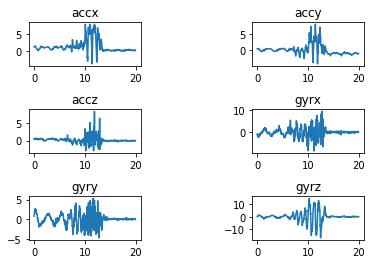

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os


# 读取原数据
name = ['accx', 'accy', 'accz', 'gyrx', 'gyry', 'gyrz', 'tag']
fopen = open(os.path.abspath('./data/rawdata/count.json'), 'r')
line = json.loads(fopen.readline())
fopen.close()

# 对每个轴原始数据进行画图
for i in range(6):
    data = np.array(line[name[i]])[50:1050]
    x = np.arange(0, 20, 0.02)
    plt.subplot('32'+str(i+1))
    plt.title(name[i])
    plt.plot(x, data)
plt.subplots_adjust(wspace =1, hspace =1)
plt.show()

可以看出，在加速计y轴上，在进行四个动作时均有一定波动，且波动幅度始终。所以我们选择加速计y轴作为计数轴
### 2.波峰检测
接下来将使用detecta包中的detect_peaks函数，用于加速计数据中波峰进行检测，下面我们将绘制加速度计y轴的波峰检测图像，代码如下：

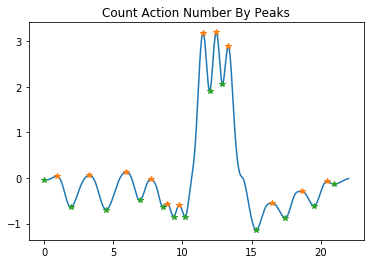

In [10]:
from detecta import detect_peaks
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import json
import os


# 设置带通滤波器参数
b, a = signal.butter(2, [0.001, 0.03],  'bandpass')
# 读取原数据
fopen = open(os.path.abspath('./data/rawdata/count.json'), 'r')
line = json.loads(fopen.readline())
fopen.close()

# 获取accy轴数据并滤波
data = np.array(line['accy'])
data = signal.filtfilt(b, a, data)

# 检测波峰和波谷
num_peak = detect_peaks(data)
num_valley = detect_peaks(-data)

# 取波峰和波谷点位置的值
peak = np.zeros(len(num_peak))
valley = np.zeros(len(num_valley))
for i in range(len(num_peak)):
    peak[i] = data[num_peak[i]]
for i in range(len(num_valley)):
    valley[i] = data[num_valley[i]]

# 画出图像
x = np.arange(0, len(data)*2/100, 0.02)
plt.plot(x, data)
plt.plot(num_peak*2/100, peak, '*')
plt.plot(num_valley*2/100, valley, '*')
plt.title('Count Action Number By Peaks')
plt.show()

以上图像为20秒内四个动作各做三次的加速计y轴图像，累计进行了12次动作。可以看到波峰对于每个动作都能进行很好的检测，并能够准确的计数。这同时也证明了波峰计数的可行性。

## 实际运用
在实际运用时，我们将使用微信小程序作为交互页面，并通过服务器实时通讯，将已经生成好的随机森林模型和波峰检测算法进行部署，以下仅节选部分代码，完整代码请在项目的github中查看：
### 1.小程序端部署
用户先进行系统的选择，用于区分ios用户和Android用户，当用户开始识别时，微信小程序将会以每一秒的频率，将当前数据发送至服务器进行识别：

```javascript
// 主函数
sendTest: function () {
    var _this = this
    if (this.data.tag == false) {
    // 判断是否已经选择手机系统
      if (this.data.type != 0){
        this.setData({
          tag: true,
          countnum1: 0,
          countnum2: 0,
          countnum3: 0,
          countnum4: 0,
        })
        // 打开音频文件
        this.innerAudioContext1 = wx.createInnerAudioContext()
        this.innerAudioContext1.loop = false
        wx.setInnerAudioOption({
          obeyMuteSwitch: false,
        })
        this.innerAudioContext1.src = 'cloud://charlie-mf4i1.6368-charlie-mf4i1-1301400124/start.mp3';
        this.innerAudioContext1.autoplay = true
          
        // 进入识别循环，每一秒进行一次识别
        _this.loop1 = setInterval(function () {
          _this.startTest()
          setTimeout(function () {
            if (_this.data.start == true) {
            // 发送数据至服务器
              wx.request({
                url: 'https://www.inifyy.cn:8080',
                header: {
                  'content-type': 'application/json'
                },
                data: {
                  accx: _this.data.accxo + ',' + _this.data.accxn,
                  accy: _this.data.accyo + ',' + _this.data.accyn,
                  accz: _this.data.acczo + ',' + _this.data.acczn,
                  gyrx: _this.data.gyrxo + ',' + _this.data.gyrxn,
                  gyry: _this.data.gyryo + ',' + _this.data.gyryn,
                  gyrz: _this.data.gyrzo + ',' + _this.data.gyrzn,
                  type: _this.data.type,
                },
                method: "post",
                success(res) {
                  _this.setData({
                    result: res.data,
                  })
                },
              })
            } else {
              wx.request({
                url: 'https://www.inifyy.cn:8080/clear',
                method: "post",
              })
              _this.setData({
                start: true,
              })
              _this.innerAudioContext2.destroy()
            }
          }, 1050)
        }, 1100)
          
        // 进行语音播报，播报当前进行动作，每3秒播报一次
        if (_this.data.play == true) {
          _this.loop2 = setInterval(function () {
            if (_this.data.result != '0') {
              _this.innerAudioContext2 = wx.createInnerAudioContext()
              _this.innerAudioContext2.loop = false
              wx.setInnerAudioOption({
                obeyMuteSwitch: false,
              })
              _this.innerAudioContext2.src = 'cloud://charlie-mf4i1.6368-charlie-mf4i1-1301400124/activity' + _this.data.result + '.mp3';
              _this.innerAudioContext2.autoplay = true
              setTimeout(function () {
                _this.innerAudioContext2.destroy()
              }, 1500)
            }
          }, 3000)
        }
        
        // 计数循环，每4秒发送一次请求，计算当前每个动作进行多少次
        _this.loop3 = setInterval(function () {
          if(_this.data.counttime == 0 || Number(_this.data.resultold) == 0){
            _this.setData({
              counttime: _this.data.counttime + 1,
            })
          }else{
            wx.request({
              url: 'https://www.inifyy.cn:8080/count',
              method: "post",
              data: {
                type: _this.data.type,
              },
              success(res) {
                var temp = res.data.slice(1,-2).split(". ")
                _this.setData({
                  countnum1: Number(temp[0]),
                  countnum2: Number(temp[1]),
                  countnum3: Number(temp[2]),
                  countnum4: Number(temp[3]),
                })
              },
            })
          }
          _this.setData({
            resultold: _this.data.result,
          })
        },4400)
      }else{
        wx.showToast({
          icon: 'none',
          title: '请选择手机对应的系统！',
        })
      }
    }
  },
 ```

### 2.服务器端部署
服务器使用python的flask框架进行收发数据，并调用机器学习模型和波峰检测进行实时计算，部分代码如下：

```python
from flask import Flask, request
import sys
import numpy as np
import joblib
import feature
from scipy import signal
from detecta import detect_peaks
app = Flask(__name__)


# 分别读取ios和安卓的模型
weight1 = np.loadtxt('./model/data1.txt')
weight2 = np.loadtxt('./model/data2.txt')
RF1 = joblib.load('model/rf1.model')
RF2 = joblib.load('model/rf2.model')
# 特征提取文件
feature_class = feature.getFeature()
name = ['accx', 'accy', 'accz', 'gyrx', 'gyry', 'gyrz']
# 计数和识别使用的滤波器
b1, a1 = signal.butter(2, [0.001, 0.03],  'bandpass')
b2, a2 = signal.butter(2, [0.001, 0.06],  'bandpass')
b3, a3 = signal.butter(8, 0.2, 'lowpass')
# 初始化全局变量
accTotal = hiitTotal = np.array([])
count = 0


# 特征权重函数
def select(feature_list, flag):
    select_list = []
    for i in range(len(globals()['weight'+flag])):
        if globals()['weight'+flag][i] == 1:
            select_list = np.append(select_list, feature_list[i])
    return select_list


# 动作识别函数
@app.route('/', methods=['post'])
def identify():
    global accTotal, count, hiitTotal
    inputs = []
    data = request.get_json()
    # 逐个轴提取特征
    for i in range(6):
        temp = np.array(list(map(float, data[name[i]].split(','))))
        temp = signal.filtfilt(b3, a3, temp)
        fea = feature_class.get_all_feature(temp)
        inputs = np.append(inputs, fea)
    # 检测是否处于静止
    if (inputs[1]-inputs[0]) > 0.05 and inputs[0] < 0.7:
        inputs = select(inputs, str(data['type'])).reshape(1, -1)
        result = globals()['RF'+str(data['type'])].predict(inputs)
        result = result[0]
    else:
        result = 0
    # 将识别结果保存，用于计数
    if count % 2 == 0:
        accTotal = np.append(accTotal, np.array(list(map(float, data['accy'].split(',')))))
    hiitTotal = np.append(hiitTotal, result)
    if count == 0:
        hiitTotal = np.append(hiitTotal, hiitTotal)
    count += 1
    print(str(result))
    return str(result)


# 计数函数
@app.route('/count', methods=['post'])
def countnum():
    global accTotal, count, hiitTotal
    numlist = {'1': 50, '2': 17}
    data = request.get_json()
    actNum = np.array([])
    countTotal = np.zeros(4)
    # 计数滤波
    filtedData = signal.filtfilt(globals()['b'+str(data['type'])], globals()['a'+str(data['type'])], accTotal)
    # 检测波峰
    numpeak = detect_peaks(filtedData)
    # 计算各个动作的个数
    for i1 in range(len(numpeak)):
        actNum = np.append(actNum, hiitTotal[(numpeak[i1] - 1) // numlist[str(data['type'])]])
    for i2 in range(4):
        countTotal[i2] = sum(actNum == i2+1)
    print('count = ', countTotal)
    return str(countTotal)


# 清除函数，重置全局变量
@app.route('/clear', methods=['post'])
def clear():
    global accTotal, count, hiitTotal
    accTotal = hiitTotal = np.array([])
    count = 0
    return '0'


# 服务器文件和端口设置
if __name__ == '__main__':
    context = (sys.path[0] + '/Nginx/1_www.inifyy.cn_bundle.crt', sys.path[0] + '/Nginx/2_www.inifyy.cn.key')
    app.run(debug=1, host='172.17.0.3', port=8080, ssl_context=context)
```

## 总结
有关项目的完整代码，请查看我的github：https://github.com/Sun-Yize-SDUWH/IndoorHIIT-activity-recognition

动作识别小程序，扫描二维码访问：
<center><img src="https://inifyy.cn:4100/" width=500px></center>